In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms  import ToTensor

import matplotlib.pyplot as plt

print(f"torch: {torch.__version__}")
print(f"torcvision: {torchvision.__version__}")

torch: 1.12.1+cu113
torcvision: 0.13.1+cu113


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [5]:
image.shape

torch.Size([1, 28, 28])

In [6]:
len(train_data), len(test_data)

(60000, 10000)

In [7]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

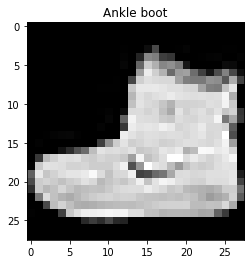

In [8]:
import matplotlib.pyplot as plt
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);

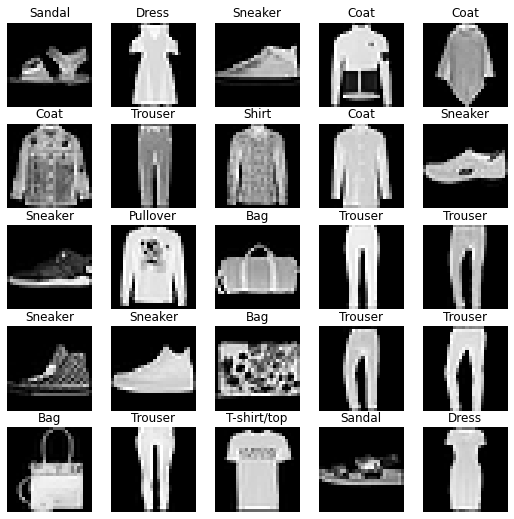

In [9]:
fig = plt.figure(figsize=(9,9))
rows, cols= 5, 5
for i in range(1, rows*cols+1):
    rand_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[rand_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

In [10]:
from  torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

len(train_dataloader), len(test_dataloader)

(1875, 313)

In [11]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

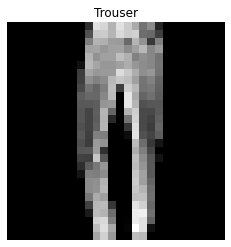

In [12]:
rand_idx = torch.randint(0, 32, size=[1]).item()
img, label = train_features_batch[rand_idx], train_labels_batch[rand_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

In [13]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [14]:
class ModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
            nn.ReLU()
        )
    def forward(self, x):
        return self.layer_stack(x)

model0 = ModelV0(784, 10, len(class_names)).to(device)
model0

ModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [15]:
def accuracy(y_true, y_pred):
    return ((torch.eq(y_true, y_pred).sum().item())/len(y_pred)) * 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model0.parameters(), lr=0.1)

In [16]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device = None):
    t = end-start
    print(f"Train time on {device}: {t:.3f} seconds")

In [17]:
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    train_loss = 0
    model.train()

    for X, y in data_loader:
        X = X.to(device)
        y = y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss+=loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(data_loader)
    return train_loss

def test_step(model: nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              acc_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss+=loss
            acc = acc_fn(y, y_pred.argmax(dim=1))
            test_acc+=acc
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    return test_loss, test_acc

In [18]:
from tqdm.auto import tqdm

start = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")

    train_loss = train_step(model0, train_dataloader, loss_fn, optimizer, device)
    
    test_loss, acc = test_step(model0, test_dataloader, loss_fn, accuracy, device)

    print(f"Train Loss: {train_loss:.5f} Test Loss: {test_loss:.5f} Acc: {acc:.5f}")        

end = timer()
print_train_time(start, end, device=str(next(model0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 0.88676 Test Loss: 0.53450 Acc: 80.69089
Epoch: 1
Train Loss: 0.48137 Test Loss: 0.48358 Acc: 82.70767
Epoch: 2
Train Loss: 0.44633 Test Loss: 0.47755 Acc: 83.49641
Train time on cuda:0: 25.057 seconds


In [19]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model": model.__class__.__name__, "loss":loss.item(), "acc":acc}

model0_results = eval_model(model0, test_dataloader, loss_fn, accuracy)
model0_results

{'model': 'ModelV0', 'loss': 0.4775530993938446, 'acc': 83.49640575079871}

In [20]:
class ModelV1(nn.Module):

    def __init__(self, input: int, hidden: int, output: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(input, hidden, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden, hidden, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden*7*7, output)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x

model1 = ModelV1(1, 10, len(class_names)).to(device)
model1

ModelV1(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [21]:
images = torch.randn(size=(32,3,64,64))
test_image = images[0]
images.shape, test_image.shape

(torch.Size([32, 3, 64, 64]), torch.Size([3, 64, 64]))

In [22]:
conv_layer = nn.Conv2d(in_channels=3, 
                       out_channels=10, 
                       kernel_size=5, 
                       stride=2,
                       padding=0)

test_image_through_conv = conv_layer(test_image)
test_image_through_conv.shape

torch.Size([10, 30, 30])

In [23]:
print(conv_layer.weight.shape)
print(conv_layer.bias.shape)

torch.Size([10, 3, 5, 5])
torch.Size([10])


In [24]:
max_pool_layer = nn.MaxPool2d(kernel_size=2)

test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
test_image_through_conv_and_max_pool.shape

torch.Size([10, 15, 15])

In [25]:
random_tensor = torch.randn(1,2,2)
print(random_tensor)

tensor([[[ 1.1694, -0.9609],
         [-0.9847, -1.0422]]])


In [26]:
print(random_tensor.max())
max_pool_layer(random_tensor)

tensor(1.1694)


tensor([[[1.1694]]])

In [27]:
print(random_tensor.mean())
avg_pool_layer = nn.AvgPool2d(2)
avg_pool_layer(random_tensor)

tensor(-0.4546)


tensor([[[-0.4546]]])

In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.1)

In [29]:
from tqdm.auto import tqdm

start = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}")
    train_loss = train_step(model1, train_dataloader, loss_fn, optimizer, device)
    test_loss, test_acc = test_step(model1, test_dataloader, loss_fn, accuracy, device)
    print(f"Train Loss: {train_loss:.5f} Test Loss: {test_loss:.5f} Accuracy: {test_acc:.5f}")

end = timer()

print_train_time(start, end, str(next(model1.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
Train Loss: 0.58403 Test Loss: 0.37664 Accuracy: 86.33187
Epoch 1
Train Loss: 0.34886 Test Loss: 0.34522 Accuracy: 87.57987
Epoch 2
Train Loss: 0.31300 Test Loss: 0.33416 Accuracy: 87.34026
Train time on cuda:0: 41.063 seconds


In [30]:
model1_results = eval_model(model1, test_dataloader, loss_fn, accuracy)
model1_results

{'model': 'ModelV1', 'loss': 0.33415815234184265, 'acc': 87.34025559105432}